In [11]:
# 필요한 패키지 설치
!pip install torch matplotlib numpy

In [36]:
# 코랩을 위한 한글 폰트 설정
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!fc-cache -fv

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [37]:
# 폰트 캐시 다시 생성
!rm ~/.cache/matplotlib -rf

In [38]:
# 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import torch
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [39]:
# 나눔고딕 설치 확인 및 폰트 경로 설정
import subprocess
import sys

In [40]:
# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

In [41]:
# Matplotlib 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'
mpl.font_manager.fontManager.addfont(font_path)

In [42]:
# Matplotlib(animation) 설정
plt.rcParams['animation.html'] = 'jshtml'
plt.ioff()

In [52]:
def visualize_convolution_with_calculation(input_size=(6,6), kernel_size=3, stride=1, padding=0, current_step=0):
    """
    CNN의 convolution 연산 과정을 입력 텐서 위에 커널을 오버레이하고
    현재 위치에서의 계산 과정을 함께 보여주는 함수
    """
    # 출력 크기 계산
    output_height = ((input_size[0] + 2*padding - kernel_size) // stride) + 1
    output_width = ((input_size[1] + 2*padding - kernel_size) // stride) + 1

    # 현재 커널의 위치 계산
    current_row = current_step // output_width
    current_col = current_step % output_width

    # 입력 데이터 생성 (1부터 3 사이의 다양한 값)
    input_data = np.array([
        [2, 1, 2, 3, 1, 2],
        [1, 3, 2, 1, 2, 1],
        [2, 1, 3, 2, 3, 2],
        [3, 2, 1, 1, 2, 3],
        [1, 2, 2, 3, 1, 2],
        [2, 3, 1, 2, 2, 1]
    ])
    input_tensor = torch.tensor(input_data).float().unsqueeze(0).unsqueeze(0)

    # 커널 생성 (다양한 가중치)
    kernel_data = np.array([
        [0, 1, 0],
        [1, -1, 1],
        [0, 1, 0]
    ])  # 엣지 검출과 비슷한 커널
    kernel = torch.tensor(kernel_data).float().unsqueeze(0).unsqueeze(0)

    padded_input = F.pad(input_tensor, (padding, padding, padding, padding))

    # 현재 위치의 입력값과 결과 계산
    x = current_col * stride
    y = current_row * stride
    current_input = padded_input[0, 0, y:y+kernel_size, x:x+kernel_size]

    # 컨볼루션 계산 (요소별 곱셈의 합)
    element_wise_mult = current_input * kernel[0, 0]
    result = element_wise_mult.sum().item()

    # 시각화
    fig = plt.figure(figsize=(15, 8))  # figure 크기 조정
    gs = plt.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1.5, 1])  # 높이 비율 조정

    # 1. 메인 플롯 (입력 텐서 + 커널 오버레이)
    ax_main = fig.add_subplot(gs[0, 0])

    # 전체 입력 텐서 값 표시
    for i in range(input_size[0]):
        for j in range(input_size[1]):
            ax_main.text(padding+j+0.5, padding+i+0.5, f'{input_data[i,j]}',
                        ha='center', va='center', color='black')

    # 패딩 영역과 입력 영역 표시
    padded_height = input_size[0] + 2*padding
    padded_width = input_size[1] + 2*padding
    ax_main.add_patch(Rectangle((0, 0), padded_width, padded_height,
                              fill=False, edgecolor='black', linestyle='--', alpha=0.5))
    ax_main.add_patch(Rectangle((padding, padding), input_size[1], input_size[0],
                              fill=True, facecolor='lightgray', alpha=0.3))

    # 현재 커널 위치 표시 (경고 메시지 제거를 위해 수정)
    kernel_rect = Rectangle((x, y), kernel_size, kernel_size,
                          fill=True,
                          facecolor='blue',
                          alpha=0.2,
                          linewidth=2,
                          edgecolor='blue')
    ax_main.add_patch(kernel_rect)

    # 2. 계산 과정 설명
    ax_calc = fig.add_subplot(gs[0, 1])
    ax_calc.axis('off')

    # 현재 커널 영역의 계산 과정 표시
    calculation_text = "요소별 곱셈 결과:\n\n"
    for i in range(kernel_size):
        for j in range(kernel_size):
            input_val = current_input[i, j].item()
            kernel_val = kernel[0, 0, i, j].item()
            mult_result = input_val * kernel_val
            calculation_text += f"{input_val:>4.1f} × {kernel_val:>4.1f} = {mult_result:>6.1f}\n"

    calculation_text += f"\n총 합: {result:.1f}"
    ax_calc.text(0.1, 0.5, calculation_text,
                fontproperties=font_prop,
                verticalalignment='center',
                fontsize=12)

    # 3. 출력 텐서 상태
    ax_output = fig.add_subplot(gs[1, :])
    output = np.zeros((output_height, output_width))
    output[current_row, current_col] = result

    vmax = max(abs(np.min(output)), abs(np.max(output)))
    vmin = -vmax
    im = ax_output.imshow(output, cmap='RdBu', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax_output)
    cbar.set_label('출력 값', fontproperties=font_prop)
    ax_output.set_title('현재까지의 출력 텐서', fontproperties=font_prop)

    def get_text_color(value, vmin, vmax):
        """값의 범위에 따라 적절한 텍스트 색상을 반환"""
        # 값의 범위를 0~1로 정규화
        normalized_value = (value - vmin) / (vmax - vmin)
        # 중간값(0.5) 기준으로 색상 결정
        return 'white' if normalized_value > 0.5 else 'black'

    # 출력 텐서에 값 표시
    ax_output.text(current_col, current_row, f'{result:.1f}',
                  ha='center', va='center',
                  color=get_text_color(result, vmin, vmax),
                  fontweight='bold')

    # 커널 모양 설명 추가
    kernel_desc = (
        "커널 가중치:\n"
        f"[{kernel_data[0,0]:>4.1f} {kernel_data[0,1]:>4.1f} {kernel_data[0,2]:>4.1f}]\n"
        f"[{kernel_data[1,0]:>4.1f} {kernel_data[1,1]:>4.1f} {kernel_data[1,2]:>4.1f}]\n"
        f"[{kernel_data[2,0]:>4.1f} {kernel_data[2,1]:>4.1f} {kernel_data[2,2]:>4.1f}]"
    )
    ax_main.text(padded_width + 0.5, padded_height/2, kernel_desc,
                fontproperties=font_prop, va='center')

    # 그리드 및 축 설정
    ax_main.grid(True, linestyle='--', alpha=0.3)
    ax_main.set_xlim(-0.5, padded_width + 3)  # 커널 설명을 위해 여유 공간 추가
    ax_main.set_ylim(padded_height + 0.5, -0.5)
    ax_main.set_aspect('equal')
    ax_main.set_title('컨볼루션 연산 과정', fontproperties=font_prop)

    plt.suptitle(
        f'컨볼루션 연산 시각화 (단계: {current_step+1}/{output_height*output_width})\n'
        f'입력 크기: {input_size}, 커널 크기: {kernel_size}×{kernel_size}, '
        f'스트라이드: {stride}, 패딩: {padding}',
        fontproperties=font_prop,
        y=0.98
    )

    plt.tight_layout()
    plt.show()
    return result

In [53]:
def demonstrate_calculations(input_size=(6,6), kernel_size=3, stride=1, padding=0, steps=3):
    """
    여러 단계의 컨볼루션 계산 과정을 보여주는 함수
    """
    output_height = ((input_size[0] + 2*padding - kernel_size) // stride) + 1
    output_width = ((input_size[1] + 2*padding - kernel_size) // stride) + 1
    total_steps = output_height * output_width
    steps = min(steps, total_steps)

    print(f"\n컨볼루션 연산의 처음 {steps}단계를 보여줍니다...")
    print(f"총 단계 수: {total_steps}")
    print(f"출력 크기: {output_height}×{output_width}\n")

    for step in range(steps):
        print(f"\n=== 단계 {step + 1}/{steps} ===")
        result = visualize_convolution_with_calculation(
            input_size, kernel_size, stride, padding, step
        )
        print(f"현재 위치의 출력값: {result:.1f}")
        plt.pause(1)


컨볼루션 연산의 처음 3단계를 보여줍니다...
총 단계 수: 16
출력 크기: 4×4


=== 단계 1/3 ===


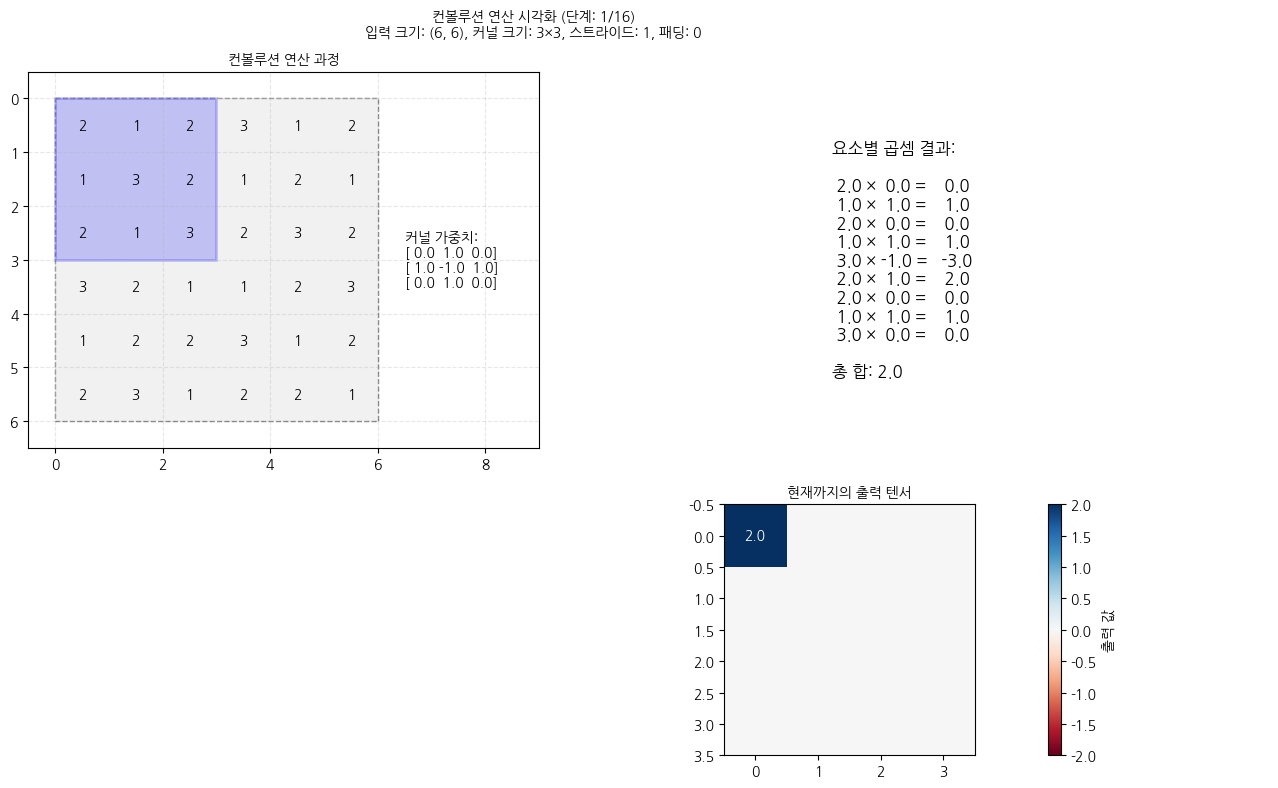

현재 위치의 출력값: 2.0

=== 단계 2/3 ===


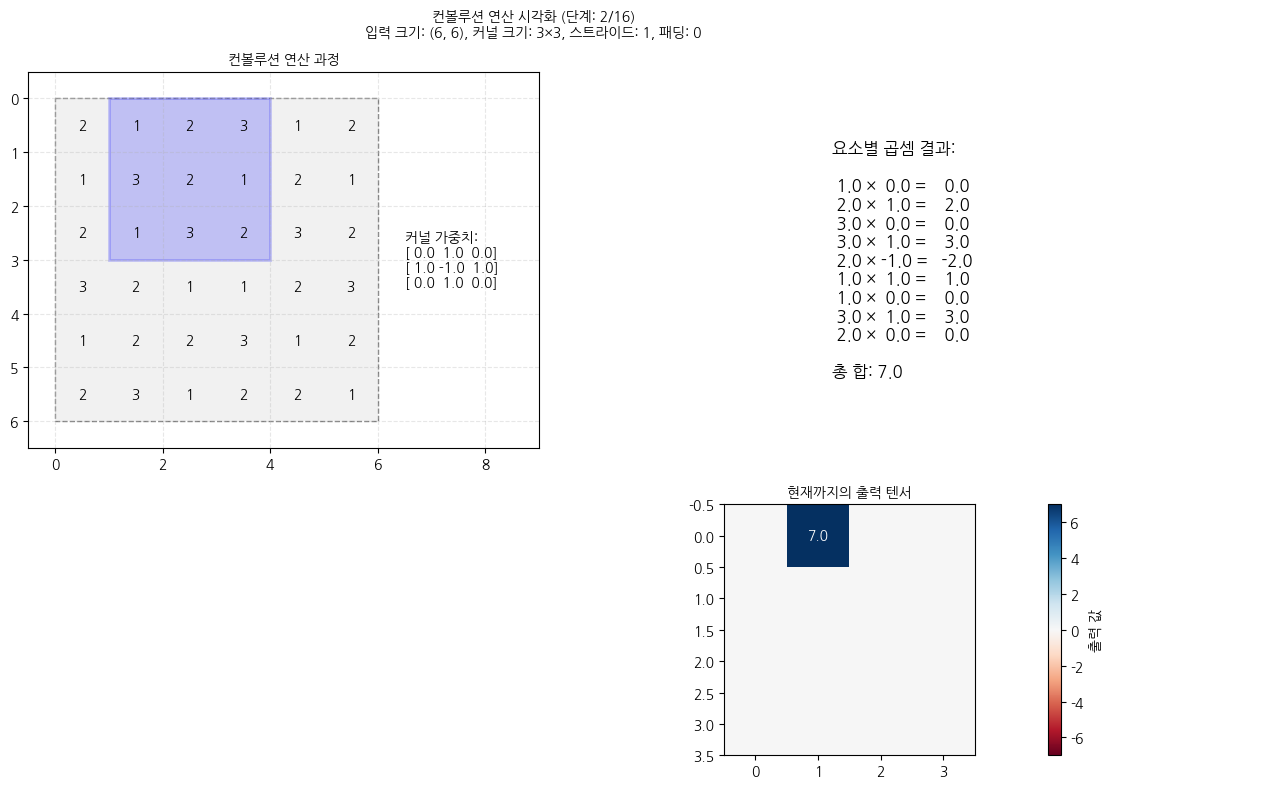

현재 위치의 출력값: 7.0

=== 단계 3/3 ===


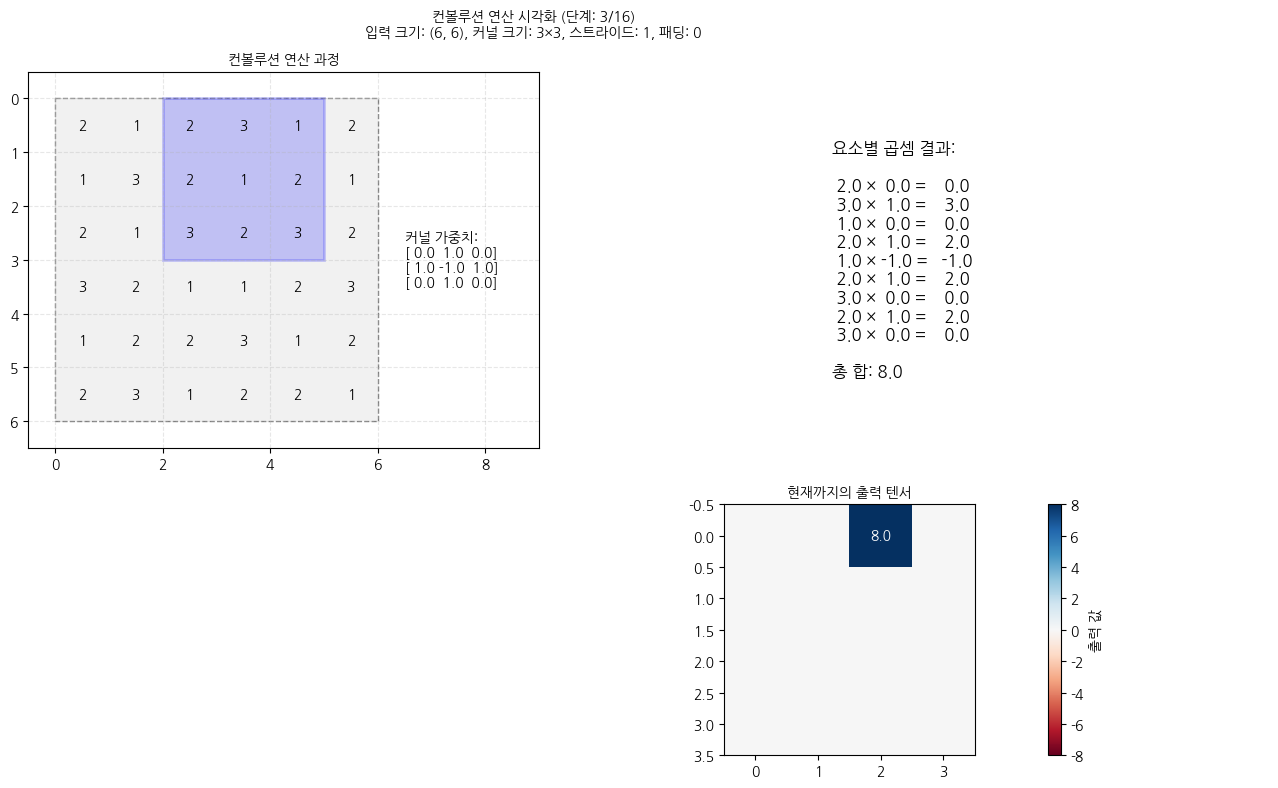

현재 위치의 출력값: 8.0


In [54]:
demonstrate_calculations(
    input_size=(6,6),
    kernel_size=3,
    stride=1,
    padding=0,
    steps=3
)

In [69]:
def create_convolution_animation(input_size=(6,6), kernel_size=3, stride=1, padding=0, interval=500, case_name="기본 컨볼루션", save_animations=False):
    # 출력 크기 계산
    output_height = ((input_size[0] + 2*padding - kernel_size) // stride) + 1
    output_width = ((input_size[1] + 2*padding - kernel_size) // stride) + 1
    total_steps = output_height * output_width

    # 입력과 커널 생성
    input_data = np.array([
    [2, 1, 2, 3, 1, 2],
    [1, 3, 2, 1, 2, 1],
    [2, 1, 3, 2, 3, 2],
    [3, 2, 1, 1, 2, 3],
    [1, 2, 2, 3, 1, 2],
    [2, 3, 1, 2, 2, 1]
    ])
    input_tensor = torch.tensor(input_data).float().unsqueeze(0).unsqueeze(0)

    kernel_data = np.array([
        [0, 1, 0],
        [1, -1, 1],
        [0, 1, 0]
    ])
    kernel = torch.tensor(kernel_data).float().unsqueeze(0).unsqueeze(0)

    # 컨볼루션 연산 미리 수행
    padded_input = F.pad(input_tensor, (padding, padding, padding, padding))
    output = F.conv2d(padded_input, kernel, stride=stride)
    result_tensor = output.squeeze().detach().numpy()

    # 현재까지의 진행상황을 저장할 배열 초기화
    current_output = np.zeros((output_height, output_width))  # nan 대신 0으로 초기화

    plt.close('all')
    fig = plt.figure(figsize=(15, 8))
    gs = plt.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[2, 1])

    ax_main = fig.add_subplot(gs[0, 0])
    ax_result = fig.add_subplot(gs[0, 1])
    ax_text = fig.add_subplot(gs[1, :])

    def update(frame):
        ax_main.clear()
        ax_text.clear()
        ax_result.clear()

        padded_height = input_size[0] + 2*padding
        padded_width = input_size[1] + 2*padding

        # 패딩 영역과 입력 영역 표시
        ax_main.add_patch(Rectangle((0, 0), padded_width, padded_height,
                                  fill=False, color='black', linestyle='--', alpha=0.5))
        ax_main.add_patch(Rectangle((padding, padding), input_size[1], input_size[0],
                                  fill=True, color='lightgray', alpha=0.3))

        # 현재 위치 계산
        current_row = frame // output_width
        current_col = frame % output_width

        # 이전 스텝들 포함하여 출력값 업데이트
        for prev_frame in range(frame + 1):
            prev_row = prev_frame // output_width
            prev_col = prev_frame % output_width
            current_output[prev_row, prev_col] = result_tensor[prev_row, prev_col]

        # 커널의 현재 위치
        x = current_col * stride
        y = current_row * stride

        # 현재 커널 위치 표시
        current_rect = Rectangle((x, y), kernel_size, kernel_size,
                               facecolor='blue', alpha=0.3,
                               linewidth=2, edgecolor='blue')
        ax_main.add_patch(current_rect)

        # 현재 출력값 표시
        if frame < total_steps:
            current_val = result_tensor[current_row, current_col]
            center_x = x + kernel_size/2
            center_y = y + kernel_size/2
            ax_main.scatter(center_x, center_y, color='red', s=100, alpha=0.7)
            ax_main.text(center_x, center_y-0.3, f'현재 합: {current_val:.1f}',
                        ha='center', va='top', color='red', weight='bold',
                        fontproperties=font_prop)

        # 메인 플롯 설정
        ax_main.grid(True, linestyle='--', alpha=0.3)
        ax_main.set_xlim(-0.5, padded_width + 0.5)
        ax_main.set_ylim(padded_height + 0.5, -0.5)
        ax_main.set_aspect('equal')
        ax_main.set_title('컨볼루션 연산 과정', fontproperties=font_prop)

        # 설명 텍스트
        description = f"""
컨볼루션 연산 파라미터:
• 입력 크기: {input_size[0]}×{input_size[1]}  • 패딩: {padding}  • 커널 크기: {kernel_size}×{kernel_size}  • 스트라이드: {stride}
• 출력 크기: {output_height}×{output_width}  • 현재 단계: {frame+1}/{total_steps}  • 현재 위치: {current_row+1}행 {current_col+1}열

범례:  ■ 입력 영역(모든 값이 1)  ■ 커널 영역(3×3 합산)  ■ 출력값(커널 영역의 합)
"""
        ax_text.text(0.5, 0.5, description, ha='center', va='center',
                    fontproperties=font_prop, fontsize=12)
        ax_text.axis('off')

        # 출력 텐서 시각화
        im = ax_result.imshow(current_output, cmap='Blues', origin='upper',
                            aspect='equal', interpolation='nearest',
                            vmin=0, vmax=np.max(result_tensor))  # 값 범위 설정

        # 출력 텐서에 값 표시 부분을 수정
        for i in range(output_height):
            for j in range(output_width):
                val = current_output[i, j]
                # if val > 0 조건을 제거하여 모든 값 표시
                color = 'white' if val > np.max(result_tensor) * 0.6 else 'black'
                ax_result.text(j, i, f'{val:.1f}', ha='center', va='center',
                              color=color, weight='bold', fontsize=14)

        # 결과 플롯 설정
        ax_result.set_xticks(np.arange(output_width))
        ax_result.set_yticks(np.arange(output_height))
        ax_result.grid(False)

        ax_result.set_xlim(-0.5, output_width - 0.5)
        ax_result.set_ylim(output_height - 0.5, -0.5)
        ax_result.set_title('출력 텐서\n(각 위치에서의 합산 결과)', fontproperties=font_prop)

        plt.suptitle(f'{case_name}\n컨볼루션 단계 {frame+1}/{total_steps}',
                    y=0.98, fontproperties=font_prop)

        plt.tight_layout()

        return (ax_main.patches + ax_main.texts + ax_main.collections +
                ax_result.texts + [im])

    anim = animation.FuncAnimation(fig, update, frames=total_steps,
                                 interval=interval, blit=True)

    if save_animations:
        safe_name = case_name.replace(" ", "_").replace("(", "").replace(")", "")
        anim.save(f'convolution_{safe_name}.gif',
                 writer='pillow', fps=1000//interval)

    plt.show()
    return anim

In [70]:
def demonstrate_all_cases(save_animations=False):
    cases = [
        ((6,6), 3, 1, 0, "기본 컨볼루션 (padding=0, stride=1)"),
        ((6,6), 3, 1, 1, "패딩 추가 (padding=1, stride=1)"),
        ((6,6), 3, 2, 0, "스트라이드 증가 (padding=0, stride=2)"),
        ((6,6), 3, 2, 1, "패딩과 스트라이드 조합 (padding=1, stride=2)")
    ]

    print("CNN 컨볼루션 연산의 다양한 케이스 시각화를 시작합니다...")
    for params in cases:
        print(f"\n{params[4]} 시각화 중...")
        create_convolution_animation(
            input_size=params[0],
            kernel_size=params[1],
            stride=params[2],
            padding=params[3],
            case_name=params[4],
            save_animations=save_animations
        )
        plt.close()


컨볼루션 시각화 시작...

1. 모든 케이스 시각화 및 GIF 저장
CNN 컨볼루션 연산의 다양한 케이스 시각화를 시작합니다...

기본 컨볼루션 (padding=0, stride=1) 시각화 중...


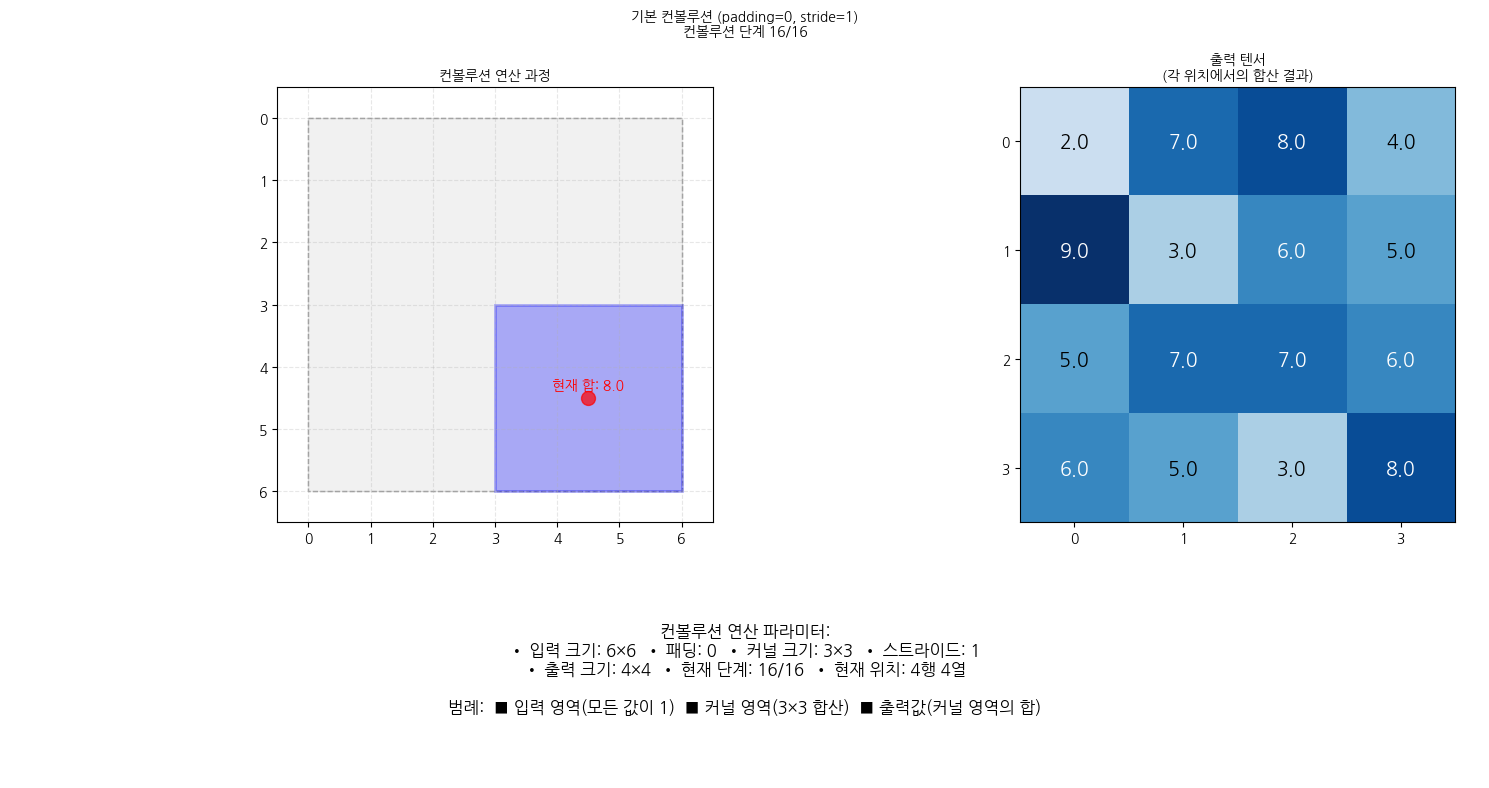


패딩 추가 (padding=1, stride=1) 시각화 중...


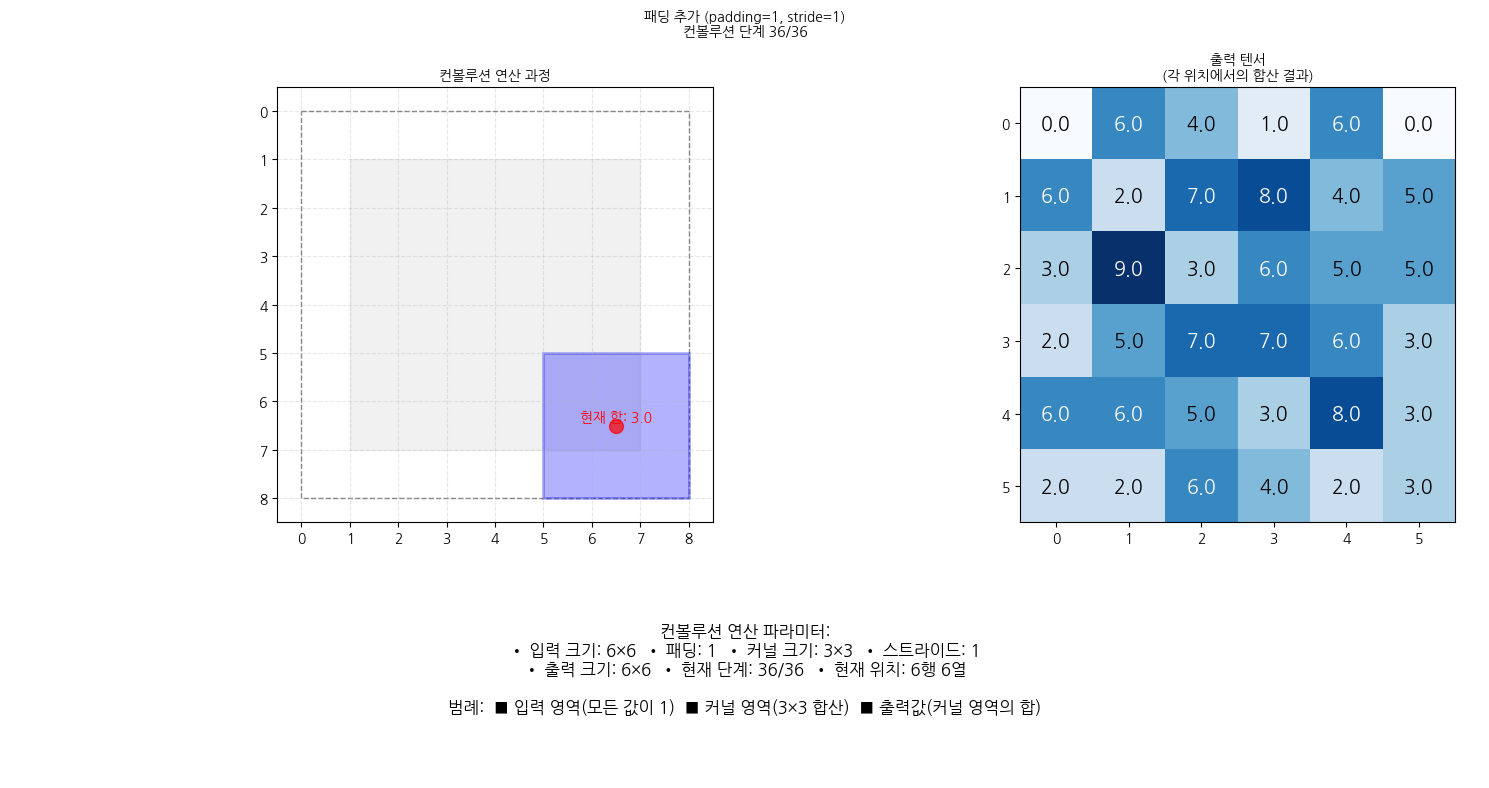


스트라이드 증가 (padding=0, stride=2) 시각화 중...


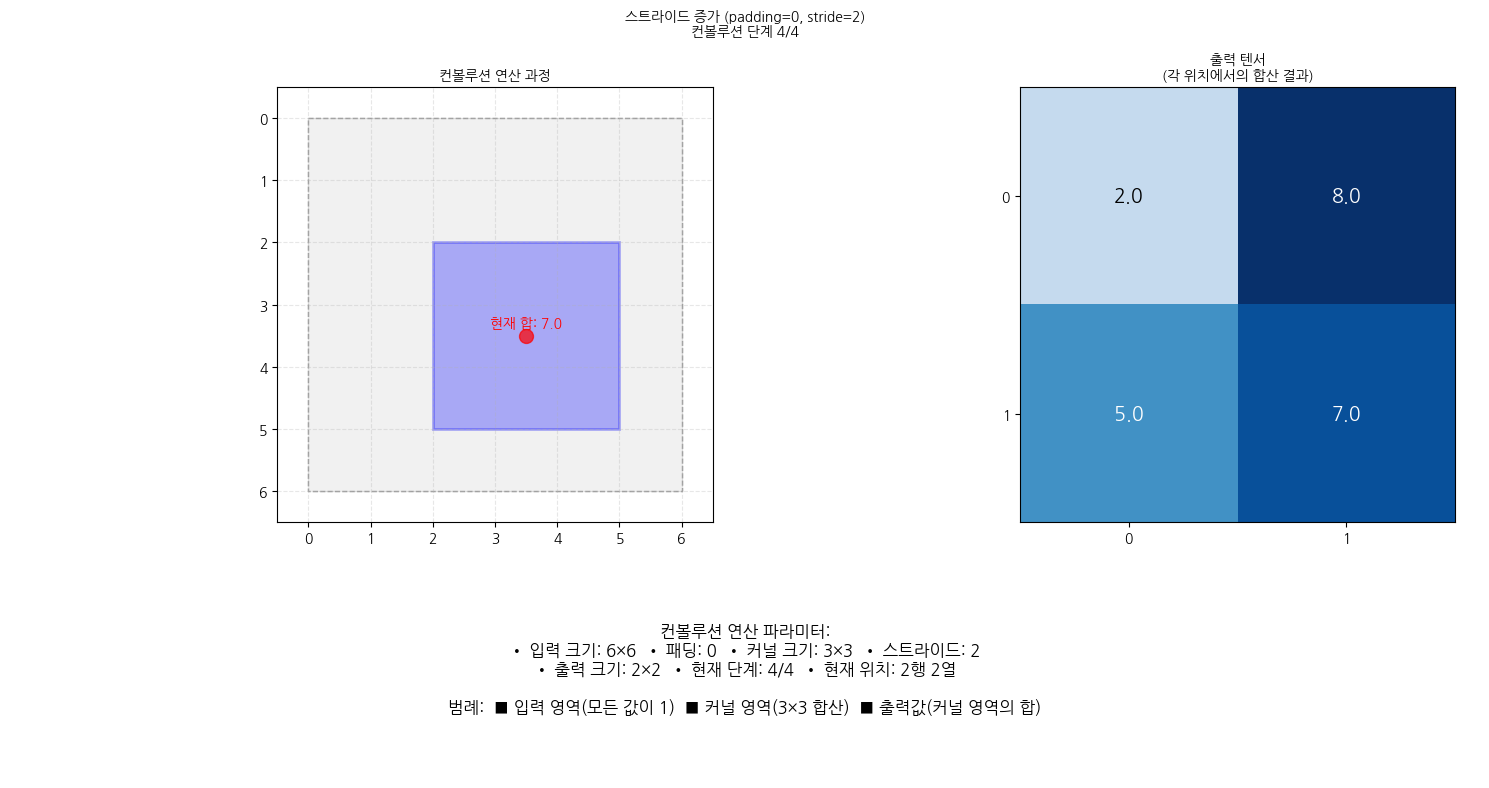


패딩과 스트라이드 조합 (padding=1, stride=2) 시각화 중...


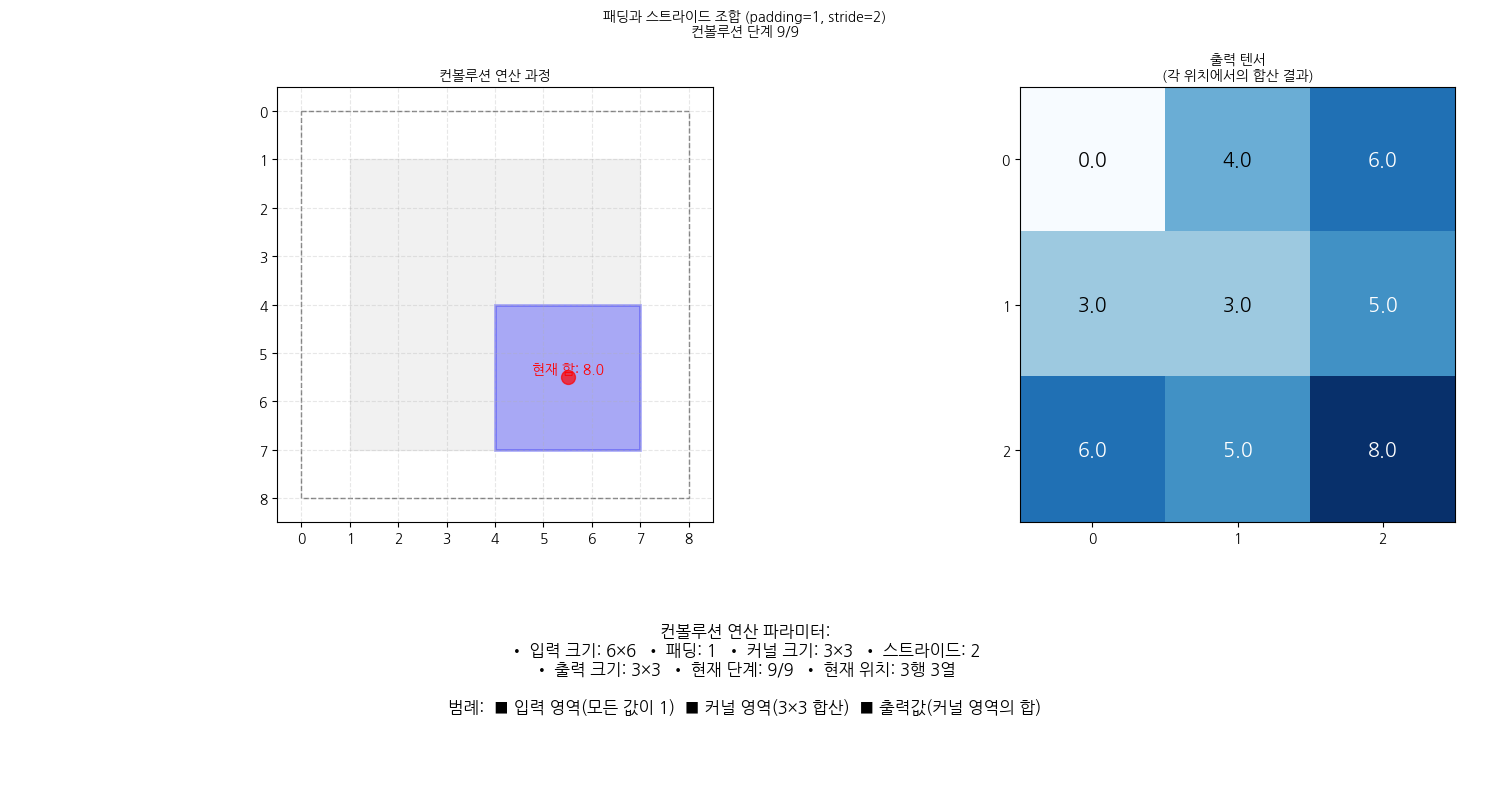

In [71]:
print("\n컨볼루션 시각화 시작...")

# 1. 모든 케이스를 GIF로 저장하며 실행
print("\n1. 모든 케이스 시각화 및 GIF 저장")
demonstrate_all_cases(save_animations=True)